In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/MyDrive/galaxy_type_classification_with_ViT/galaxy_morphology_dataset_balanced.zip" -d "/content/drive/MyDrive/galaxy_type_classification_with_ViT/"

# Setting up Environment

In [2]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

#### import os: This line imports the os module, which provides a way of using operating system-dependent functionality like reading or writing to the file system, managing environment variables, etc.

#### os.environ: This is a dictionary-like object provided by the os module that contains the environment variables of the current operating system. You can read, write, and delete environment variables using this object.

#### os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2": This line sets an environment variable named TF_CPP_MIN_LOG_LEVEL to the value "2". TensorFlow uses this environment variable to control the verbosity of log messages. The values it can take are:

- "0": All logs will be shown (default behavior).
- "1": Filter out INFO logs, showing only WARNING, ERROR, and FATAL messages.
- "2": Filter out INFO and WARNING logs, showing only ERROR and FATAL messages.
- "3": Filter out all logs except FATAL messages.

#### By setting TF_CPP_MIN_LOG_LEVEL to "2", the code instructs TensorFlow to only display ERROR and FATAL messages, thus reducing the amount of log output and making it easier to focus on important issues.








In [3]:
!pip install patchify

#### pip install numpy opencv-python glob2 scikit-learn patchify tensorflow

In [4]:
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from patchify import patchify
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping


# Don't run this cell

In [ ]:
""" Hyperparameters """
hp = {}
hp["image_size"] = 200
hp["num_channels"] = 3
hp["patch_size"] = 25
hp["num_patches"] = (hp["image_size"]**2) // (hp["patch_size"]**2)
# Image area = 200 * 200 = 40000
# Patch area = 25 * 25 = 625
# Number of patches = Image area // Patch area
hp["flat_patches_shape"] = (hp["num_patches"], hp["patch_size"]*hp["patch_size"]*hp["num_channels"])
# Shape of an unflattened patch = 25, 25, 3 (Patch width, Patch height, Number of channels)
# Shape of an flattened patch = 25 * 25 * 3 = 1875
# Shape of the image input divided into patches = 64 (number of patches), Flattened Patch shape (1875)

hp["batch_size"] = 8
hp["lr"] = 1e-4 # (1 * 10^-4 = 0.0001)
hp["num_epochs"] = 200
hp["num_classes"] = 10
hp["class_names"] = ["Barred_Spiral_Galaxies", "Cigar_Shaped_Smooth_Galaxies", "Disturbed_Galaxies", "Edge_On_Galaxies_With_Bulge", "Edge_On_Galaxies_Without_Bulge", "In_Between_Round_Smooth_Galaxies", "Merging_Galaxies", "Round_Smooth_Galaxies", "Unbarred_Loose_Spiral_Galaxies", "Unbarred_Tight_Spiral_Galaxies"]

hp["num_layers"] = 12
hp["hidden_dim"] = 768
hp["mlp_dim"] = 3072
hp["num_heads"] = 12
hp["dropout_rate"] = 0.1


# Updated Hyperparameters for Reducing Model's Complexity

In [5]:
# Updated hyperparameters
hp = {}
hp["image_size"] = 200
hp["num_channels"] = 3
hp["patch_size"] = 25
hp["num_patches"] = (hp["image_size"] ** 2) // (hp["patch_size"] ** 2)
hp["flat_patches_shape"] = (hp["num_patches"], hp["patch_size"]*hp["patch_size"]*hp["num_channels"])
hp["batch_size"] = 16
hp["lr"] = 5e-5
hp["num_epochs"] = 50
hp["num_classes"] = 10
hp["class_names"] = ["Barred_Spiral_Galaxies", "Cigar_Shaped_Smooth_Galaxies", "Disturbed_Galaxies", "Edge_On_Galaxies_With_Bulge", "Edge_On_Galaxies_Without_Bulge", "In_Between_Round_Smooth_Galaxies", "Merging_Galaxies", "Round_Smooth_Galaxies", "Unbarred_Loose_Spiral_Galaxies", "Unbarred_Tight_Spiral_Galaxies"]
hp["num_layers"] = 6
hp["hidden_dim"] = 256
hp["mlp_dim"] = 1024
hp["num_heads"] = 8
hp["dropout_rate"] = 0.1


#### Hyperparameter hp["lr"] = 1e-4 refers to the learning rate of a machine learning model, specifically for optimization algorithms used in training neural networks.

#### Learning Rate (lr): The learning rate is a crucial hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. It determines the size of the steps taken towards the minimum of the loss function during the training process.

#### 1e-4 in Detail:Scientific Notation: 1e-4 is scientific notation for 1×10−4, which equals 0.0001.

#### Impact: A learning rate of 0.0001 means the model parameters are updated very slightly with each training iteration. This can help in:

#### Stability: Reducing the risk of overshooting the minimum of the loss function.

#### Convergence: Allowing the model to make gradual progress towards the optimal solution, which can be beneficial for fine-tuning or training complex models.

#### Considerations:

- Too Low Learning Rate: If the learning rate is too low, the training process can be very slow and may get stuck in local minima.
- Too High Learning Rate: If the learning rate is too high, the model might overshoot the optimal values, leading to divergence or erratic updates.

#### Common Practice:
Learning Rate Scheduling: Often, the learning rate is dynamically adjusted during training. Techniques like learning rate decay, ReduceLROnPlateau, or using optimizers with adaptive learning rates (e.g., Adam) are common practices.

#### The concept of the "minimum of the loss function" is central to training machine learning models, particularly in supervised learning and neural networks.

#### Loss Function

- Definition: A loss function (also known as a cost function or objective function) measures the difference between the predicted values of the model and the actual values from the training data.

- Purpose: It quantifies the error made by the model, guiding the training process to minimize this error.

#### Minimum of the Loss Function

- Goal of Training: The primary goal of training a machine learning model is to find the set of parameters (weights and biases) that minimize the loss function. This ensures that the model's predictions are as close as possible to the actual data.

- Global Minimum: The global minimum is the point where the loss function has the lowest possible value. Achieving this means that the model has the best possible set of parameters for making accurate predictions on the training data.

- Local Minimum: The loss function might have several local minima, which are points where the function value is lower than the surrounding points but not necessarily the lowest possible value overall. These can sometimes trap optimization algorithms, preventing them from finding the global minimum.

#### Visualization

- Convex Functions: For simple models, the loss function might be convex, resembling a bowl shape where the bottom represents the global minimum.
- Non-Convex Functions: For complex models like deep neural networks, the loss function is often non-convex, resembling a landscape with multiple peaks and valleys.

#### Optimization
- Gradient Descent: One common method to find the minimum of the loss function is gradient descent. This iterative optimization algorithm adjusts the model parameters in the direction of the steepest descent (negative gradient) of the loss function.
- Learning Rate: The learning rate determines the step size taken during each iteration of gradient descent. A well-chosen learning rate helps in efficiently converging to the minimum.
Importance
- Model Performance: Finding the minimum of the loss function is crucial for model performance. It directly impacts how well the model generalizes to new, unseen data.
- Overfitting and Underfitting: Balancing the minimization process is important to avoid overfitting (model too closely fits the training data) and underfitting (model doesn't capture the underlying patterns in the data).

#### Example
- Consider a simple linear regression problem where we want to fit a line to a set of data points. The loss function could be the mean squared error (MSE) between the predicted values and the actual values. The training process involves adjusting the slope and intercept of the line to minimize the MSE, finding the best fit line that represents the data.

#### In summary, the minimum of the loss function represents the point where the model's predictions are most accurate with respect to the training data, and finding this minimum is the primary objective of the training process in machine learning.

In [6]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

#### The commands np.random.seed(42) and tf.random.set_seed(42) are used to set the seed for the random number generators in NumPy and TensorFlow, respectively. Setting a seed ensures reproducibility of results in experiments and model training.

#### np.random.seed(42)

- Purpose: This command sets the seed for NumPy's random number generator.

- Reproducibility: By setting a specific seed value (in this case, 42), you ensure that any subsequent calls to NumPy's random functions produce the same results each time the code is run. This is essential for debugging, comparing different models, and sharing results.

#### tf.random.set_seed(42)

- Purpose: This command sets the seed for TensorFlow's random number generator.

- Reproducibility: Similar to NumPy, setting the seed in TensorFlow ensures that operations involving randomness (e.g., initializing weights, shuffling data, dropout layers) produce the same results every time the code is run.

- Running this code again will yield the same tensor values.

#### Why Use a Specific Seed Value (e.g., 42)?

- Consistency: Using the same seed value across different libraries and experiments ensures that the randomness is consistent, allowing for fair comparisons.

- Popular Choice: The number 42 is often used as a seed value in examples and tutorials due to its cultural reference as "the answer to the ultimate question of life, the universe, and everything" from Douglas Adams' "The Hitchhiker's Guide to the Galaxy." It has no special meaning in terms of randomness, but it has become a convention in many coding communities.

#### Importance of Reproducibility

- Debugging: If you encounter an issue, being able to reproduce the exact same scenario helps in identifying and fixing the problem.
- Comparing Results: When experimenting with different models or hyperparameters, reproducibility ensures that differences in outcomes are due to the changes made and not due to variations in random initialization.
- Publishing Research: In scientific research, reproducibility is a key principle. Other researchers should be able to replicate your results using the same code and data.

#### In summary, np.random.seed(42) and tf.random.set_seed(42) are used to set the seeds for the random number generators in NumPy and TensorFlow, respectively, ensuring that the code produces the same random numbers each time it is run, thereby achieving reproducibility of results.

#### Function to create folders to save different files created during the project execution

In [7]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [8]:
def load_data(path, split=0.1): # 80 % - Training, 10 % - Validation, 10 % - Testing
    images = shuffle(glob(os.path.join(path, "*", "*.jpg"))) # Shuffling is important so that it doesn't happen that some classes are not included in any of the 3 sets, all sets should have all classes

    # split_size = int(len(images) * split)
    # print(images)
    # print(split_size)
    train_x, valid_x = train_test_split(images, test_size=split, random_state=42) # 90 % - Train, 10 % - Validation
    train_x, test_x = train_test_split(train_x, test_size=split, random_state=42) # From the 90 % in Train, 90 % in Train & 10 % in Test

    return train_x, valid_x, test_x

In [9]:
def process_image_label(path):
    """ Reading images """
    path = path.decode() # Comment it for checking the image shape as there is no decode function for string objects  # this is useful when the function is going through the tensorflow function in the parse function
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (hp["image_size"], hp["image_size"]))
    image = image/255.0 # Comment this line to save the patches without normalizing, else the patches would be black
    # print(image.shape) # For printing the shape of images # (200, 200, 3)

    # """ Preprocessing to patches """
    patch_shape = (hp["patch_size"], hp["patch_size"], hp["num_channels"]) # Patch shape is basically patch width, patch height and patch channels
    patches = patchify(image, patch_shape, hp["patch_size"]) # image to be converted to patches, shape for the patches being generated and the step size, basically if the patch size is 25, after 25 pixels along the width or height of the image, next patch should start so 25 (hp["patch_size"]) is our step size here
    # print(patches.shape) # For printing the shape of patches # (8, 8, 1, 25, 25, 3) : 8*8*1 = 64 patches of shape (25,25,3)

    # For saving the patches images
    # patches = np.reshape(patches, (64, 25, 25, 3))
    # for i in range(64):
    #      cv2.imwrite(f"files/{i}.png", patches[i])

    patches = np.reshape(patches, hp["flat_patches_shape"])
    patches = patches.astype(np.float32)

    # """ Label """
    # print(path)
    class_name = path.split("/") # To split the path to get the class name
    # print(class_name)
    class_name = path.split("/")[-2] # We'll grab the name of the class folder from the path which is always the 2nd last in the path of an image
    # C:\\Users\\OMOLP094\\Desktop\\Galaxy-Type-Prediction-With-Vision-Transformer\\galaxy_type_dataset\\Barred_Spiral_Galaxies\\image_7941_5.jpg
    # [C:,Users,OMOLP094,Desktop,Galaxy-Type-Prediction-With-Vision-Transformer,galaxy_type_dataset,Barred_Spiral_Galaxies,image_7941_5.jpg]

    # print(class_name) # To print the class name
    class_idx = hp["class_names"].index(class_name) # To get the index (Numerical label) for the class name
    # print(class_idx) # To print the class index
    class_idx = np.array(class_idx, dtype=np.int32) # Converting class index to int32 datatype array

    return patches, class_idx

In [10]:
def parse(path): # The parse function is designed to process image data and their corresponding labels, transforming them into a format suitable for machine learning models in TensorFlow.
    patches, labels = tf.numpy_function(process_image_label, [path], [tf.float32, tf.int32])
    labels = tf.one_hot(labels, hp["num_classes"])

    patches.set_shape(hp["flat_patches_shape"])
    labels.set_shape(hp["num_classes"])

# tf.numpy_function: This TensorFlow function wraps a Python function (in this case, process_image_label) so that it can be used in TensorFlow's computational graph. It allows the integration of arbitrary Python code within a TensorFlow pipeline.
# process_image_label: This is the custom function that processes the input image and extracts both the image data (patches) and the label.
# [path]: This argument passes the input path to the process_image_label function.
# [tf.float32, tf.int32]: These are the expected output data types of the process_image_label function, with patches being a float32 tensor and labels being an int32 tensor.
# tf.one_hot: This TensorFlow function converts the integer labels into one-hot encoded vectors. This is commonly used in classification problems where the label needs to be represented as a vector of zeros with a single one at the index of the correct class.
# hp["num_classes"]: This indicates the number of classes in the classification problem. The resulting one-hot vector will have this length.

    return patches, labels

In [11]:
def tf_dataset(images, batch=16):
    ds = tf.data.Dataset.from_tensor_slices((images))
    ds = ds.map(parse).batch(batch).prefetch(16) # the prefetch function would grab 8 batches while a particular batch is being processed
    return ds

In [12]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [13]:
class ClassToken(Layer):
    def __init__(self):
        super().__init__()
    # trainable / learnable class embedding
    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value = w_init(shape=(1, 1, input_shape[-1]), dtype=tf.float32),
            trainable = True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]

        cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])
        cls = tf.cast(cls, dtype=inputs.dtype)
        return cls

In [14]:
def mlp(x, cf):
    x = Dense(cf["mlp_dim"], activation="gelu")(x)
    x = Dropout(cf["dropout_rate"])(x)
    x = Dense(cf["hidden_dim"])(x)
    x = Dropout(cf["dropout_rate"])(x)
    return x

In [15]:
def transformer_encoder(x, cf):
    skip_1 = x # For skip connections
    x = LayerNormalization()(x)
    x = MultiHeadAttention(
        num_heads=cf["num_heads"], key_dim=cf["hidden_dim"]
    )(x, x)
    x = Add()([x, skip_1])

    skip_2 = x
    x = LayerNormalization()(x)
    x = mlp(x, cf)
    x = Add()([x, skip_2])

    return x

In [16]:
def ViT(cf):
    """ Inputs """
    input_shape = (cf["num_patches"], cf["patch_size"]*cf["patch_size"]*cf["num_channels"])
    inputs = Input(input_shape)     # (None, 64, 1875) (None - batch size, 64 - number of patches in an image and 1875 - patch width * patch height * patch channels)
    # print(inputs.shape)

    """ Patch Embeddings + Position Embeddings """
    patch_embed = Dense(cf["hidden_dim"])(inputs)   ## (None, 256, 768)
    # print(patch_embed.shape) # (None, 64, 768)

    positions = tf.range(start=0, limit=cf["num_patches"], delta=1) # delta is the step
    # print(positions)

    pos_embed = Embedding(input_dim=cf["num_patches"], output_dim=cf["hidden_dim"])(positions) ## (256, 768)
    # print(pos_embed.shape) ## (64, 768)
    embed = patch_embed + pos_embed
    # print(embed.shape) ## (None, 64, 768)

    """ Adding Class Token """
    token = ClassToken()(embed)
    x = Concatenate(axis=1)([token, embed]) ## (token - learnable class embedding & position embeddings of patches)
    # print(x.shape) # (None, 65, 768) (none - batch size, 65 - position embeddings for the 64 patches + 1 trainable / learnable class embedding, 768 - flattened patch)

    for _ in range(cf["num_layers"]):
        x = transformer_encoder(x, cf)

    # print(x.shape) # output of the transformer encoder block # (None, 65, 768)

    """ Classification Head """
    x = LayerNormalization()(x)     ## (None, 257, 768)
    x = x[:, 0, :]
    # print(x.shape) # (None, 768) # Input for the classification layer
    x = Dense(cf["num_classes"], activation="softmax")(x)
    print(x.shape) # (None, 10) # Output for the classification layer

    model = Model(inputs, x)
    return model

# Don't run this cell

In [ ]:
config = {}
config["num_layers"] = 12
config["hidden_dim"] = 768
config["mlp_dim"] = 3072
config["num_heads"] = 12
config["dropout_rate"] = 0.1
config["num_patches"] = 64
config["patch_size"] = 25
config["num_channels"] = 3
config["num_classes"] = 10

# Updated Model Configurations

In [17]:
config = {}
config["num_layers"] = hp["num_layers"]
config["hidden_dim"] = hp["hidden_dim"]
config["mlp_dim"] = hp["mlp_dim"]
config["num_heads"] = hp["num_heads"]
config["dropout_rate"] = hp["dropout_rate"]
config["num_patches"] = hp["num_patches"]
config["patch_size"] = hp["patch_size"]
config["num_channels"] = hp["num_channels"]
config["num_classes"] = hp["num_classes"]

In [18]:
model = ViT(config)

(None, 10)


In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 1875)]           0         []                            
                                                                                                  
 dense (Dense)               (None, 64, 256)              480256    ['input_1[0][0]']             
                                                                                                  
 tf.__operators__.add (TFOp  (None, 64, 256)              0         ['dense[0][0]']               
 Lambda)                                                                                          
                                                                                                  
 class_token (ClassToken)    (None, 1, 256)               256       ['tf.__operators__.add[0][

In [23]:
file_storage_path = "/content/drive/MyDrive/galaxy_type_classification_with_ViT_and_CNN"

In [31]:
""" Paths """
dataset_path = "/content/drive/MyDrive/galaxy_type_classification_with_ViT_and_CNN/galaxy_morphology_dataset_balanced"

In [25]:
model_path = os.path.join(file_storage_path, "model")


In [26]:
print(model_path)

/content/drive/MyDrive/galaxy_type_classification_with_ViT_and_CNN/model


In [27]:
csv_path = os.path.join(file_storage_path, "model_history", "log.csv")

In [28]:
print(csv_path)

/content/drive/MyDrive/galaxy_type_classification_with_ViT_and_CNN/model_history/log.csv


In [29]:
os.makedirs(os.path.dirname(model_path), exist_ok=True)
os.makedirs(os.path.dirname(csv_path), exist_ok=True)

In [32]:
""" Dataset """
train_x, valid_x, test_x = load_data(dataset_path)
print(f"Train: {len(train_x)} - Valid: {len(valid_x)} - Test: {len(test_x)}") # For checking the splits

Train: 2604 - Valid: 322 - Test: 290


In [33]:
len(train_x)

2604

In [34]:
from collections import Counter

def extract_class_from_path(path):
    # Extract the class name from the path
    parts = path.split('/')
    return parts[-2]  # The class name is the second last part

# Extract class names from all paths
class_names = [extract_class_from_path(path) for path in train_x]

# Count occurrences of each class
class_counts = Counter(class_names)

# Print the counts
for class_name, count in class_counts.items():
    print(f"Class '{class_name}': {count} images")

Class 'Cigar_Shaped_Smooth_Galaxies': 260 images
Class 'Disturbed_Galaxies': 263 images
Class 'Unbarred_Tight_Spiral_Galaxies': 252 images
Class 'Unbarred_Loose_Spiral_Galaxies': 264 images
Class 'Edge_On_Galaxies_With_Bulge': 247 images
Class 'Round_Smooth_Galaxies': 265 images
Class 'Edge_On_Galaxies_Without_Bulge': 257 images
Class 'Merging_Galaxies': 270 images
Class 'In_Between_Round_Smooth_Galaxies': 267 images
Class 'Barred_Spiral_Galaxies': 259 images


In [35]:
train_ds = tf_dataset(train_x, batch=hp["batch_size"])
valid_ds = tf_dataset(valid_x, batch=hp["batch_size"])

In [36]:
train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 1875), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [37]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [38]:
""" Model """
model = ViT(hp)
model.compile(
  loss="categorical_crossentropy", # for Multiclass classification
  optimizer=tf.keras.optimizers.Adam(hp["lr"], clipvalue=1.0),
  metrics=["acc"] # Accuracy is the main metric
)

(None, 10)


In [39]:
hp['num_epochs']

50

In [41]:
callbacks = [
  ModelCheckpoint(model_path, monitor='val_loss', verbose=1, save_best_only=True), # Saves the model weights when the validation loss starts reducing
  ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-10, verbose=1), # decreases learning rate when validation loss starts decreasing
  CSVLogger(csv_path), # Saves the training logs
  EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=False), # If the validation loss doesn't decreases for continuous 50 epoch, this will stop the training
]

In [42]:
model.fit(
    train_ds,
    epochs = 100, # epochs=hp["num_epochs"]
    validation_data=valid_ds,
    callbacks=callbacks
)

Epoch 1/100
163/163 [==============================] - ETA: 0s - loss: 2.4490 - acc: 0.1094
Epoch 1: val_loss improved from inf to 2.25475, saving model to /content/drive/MyDrive/galaxy_type_classification_with_ViT_and_CNN/model
163/163 [==============================] - 710s 4s/step - loss: 2.4490 - acc: 0.1094 - val_loss: 2.2548 - val_acc: 0.1925 - lr: 5.0000e-05
Epoch 2/100
163/163 [==============================] - ETA: 0s - loss: 2.1789 - acc: 0.1809
Epoch 2: val_loss improved from 2.25475 to 2.09446, saving model to /content/drive/MyDrive/galaxy_type_classification_with_ViT_and_CNN/model
163/163 [==============================] - 91s 558ms/step - loss: 2.1789 - acc: 0.1809 - val_loss: 2.0945 - val_acc: 0.2205 - lr: 5.0000e-05
Epoch 3/100
163/163 [==============================] - ETA: 0s - loss: 2.0378 - acc: 0.2362
Epoch 3: val_loss improved from 2.09446 to 1.95328, saving model to /content/drive/MyDrive/galaxy_type_classification_with_ViT_and_CNN/model
163/163 [================

In [43]:
# Save the model
model.save('/content/drive/MyDrive/galaxy_type_classification_with_ViT_and_CNN/Vit_Model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [44]:
# Save the model
model.save('/content/drive/MyDrive/galaxy_type_classification_with_ViT_and_CNN/Vit_Model.keras')

In [45]:
len(test_x)

290

In [46]:
# Load and preprocess test data
path_to_test_data = 'path_to_your_test_data_directory'
test_dataset = tf.data.Dataset.from_tensor_slices(test_x)
test_dataset = test_dataset.map(parse)
test_dataset = test_dataset.batch(16)  # Adjust batch size as necessary

model.load_weights('/content/drive/MyDrive/galaxy_type_classification_with_ViT_and_CNN/Vit_Model.h5')  # Load your trained model weights

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f"Test Accuracy: {test_accuracy}")

19/19 [==============================] - 76s 4s/step - loss: 1.4027 - acc: 0.6069
Test Accuracy: 0.6068965792655945


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [48]:
# Step 1: Make predictions on test dataset
predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)

19/19 [==============================] - 5s 190ms/step


In [49]:
# Step 2: Get true labels from test dataset
true_classes = np.concatenate([y for _, y in test_dataset], axis=0)
true_classes = np.argmax(true_classes, axis=1)

In [50]:
# Step 3: Compute confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

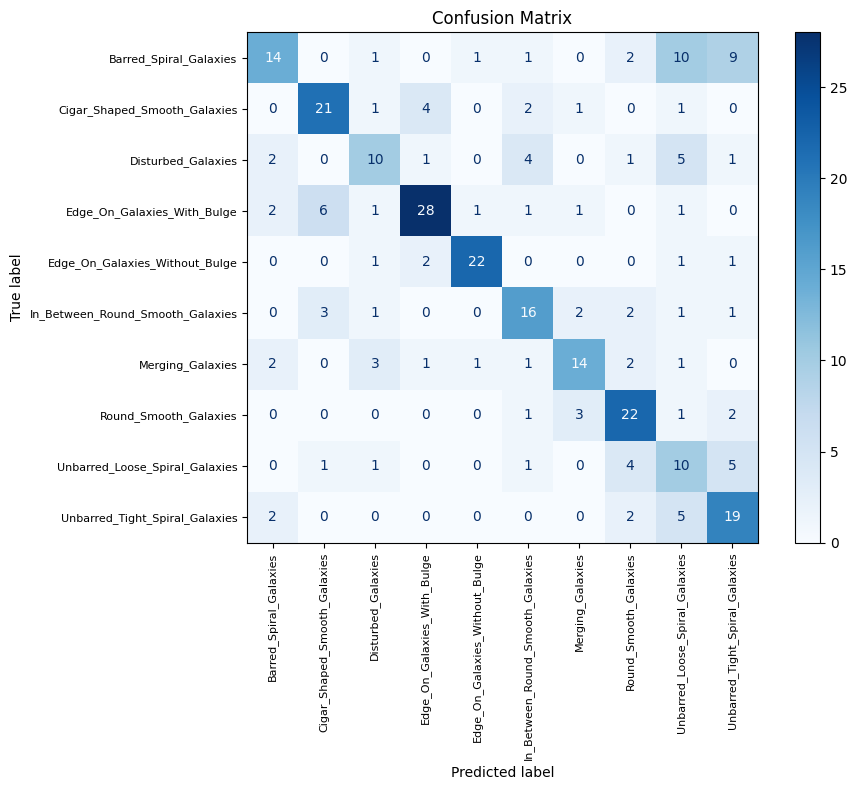

In [52]:
# Step 4: Plot confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=hp["class_names"])
ax = disp.plot(cmap=plt.cm.Blues, values_format='.4g', ax=plt.gca(), xticks_rotation='vertical')

# Customize tick labels
plt.xticks(fontsize=8, rotation='vertical')
plt.yticks(fontsize=8)

plt.title('Confusion Matrix', fontsize=12)
plt.tight_layout()
plt.show()

In [53]:
import pandas as pd

In [54]:
training_logs = pd.read_csv("/content/drive/MyDrive/galaxy_type_classification_with_ViT_and_CNN/model_history/log.csv")

In [55]:
training_logs.head()

,epoch,acc,loss,lr,val_acc,val_loss
0,0,0.109447,2.449040,0.00005,0.192547,2.254750
1,1,0.180876,2.178905,0.00005,0.220497,2.094459
2,2,0.236175,2.037791,0.00005,0.285714,1.953282
3,3,0.297235,1.893944,0.00005,0.338509,1.831572
4,4,0.360599,1.745230,0.00005,0.347826,1.665750


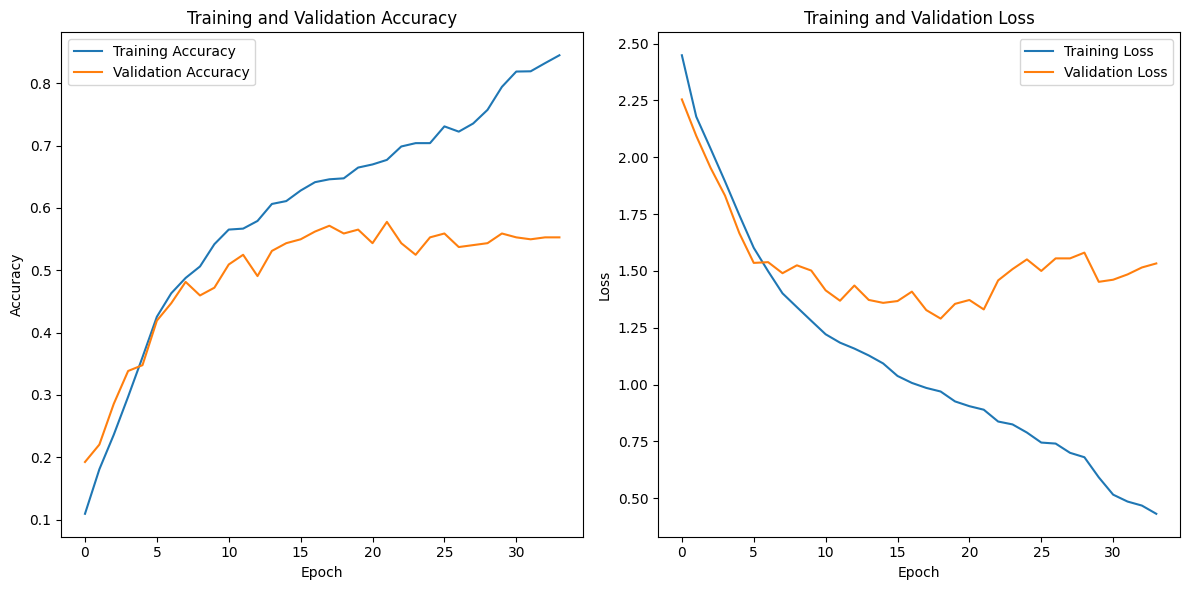

In [56]:
# Plotting
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(training_logs['epoch'], training_logs['acc'], label='Training Accuracy')
plt.plot(training_logs['epoch'], training_logs['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(training_logs['epoch'], training_logs['loss'], label='Training Loss')
plt.plot(training_logs['epoch'], training_logs['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

<hr>
<hr>